In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "../ResearchData/Respiratory_Sample_data_randamized.csv"

# ----------------------------
# Load data
# ----------------------------
df = pd.read_csv(DATA_PATH)

# ----------------------------
# Clean target (annual count)
# treat_consluation is string-like; "-" means 0
# ----------------------------
y = df["treat_consluation"].astype(str).str.strip().replace({"-": "0", "": "0"})
df["y_annual"] = pd.to_numeric(y, errors="coerce").fillna(0).astype(int)

# ----------------------------
# Clean exposure
# ----------------------------
df["Earned_Days"] = pd.to_numeric(df["Earned_Days"], errors="coerce")
df = df[df["Earned_Days"].notna() & (df["Earned_Days"] > 0)].copy()

# ----------------------------
# Clean categorical fields
# ----------------------------
df["AGEBAND"] = df["AGEBAND"].astype(str).str.strip()
df = df[df["AGEBAND"].ne("Out of range")].copy()

df["gender"] = df["gender"].astype(str).str.strip()
df["nationality"] = df["nationality"].astype(str).str.strip()
df["dependency"] = df["dependency"].astype(str).str.strip()

df.head(), df.shape


(   treat_year  AGEBAND gender marital_status nationality dependency  \
 0        2019  025-029      M         SINGLE    NEPALESE     MEMBER   
 1        2019  020-024      M         SINGLE    NEPALESE     MEMBER   
 2        2019  035-039      M        MARRIED    NEPALESE     MEMBER   
 3        2019  030-034      M        MARRIED    NEPALESE     MEMBER   
 4        2019  025-029      M        MARRIED    NEPALESE     MEMBER   
 
              city dis_code dis_code_description  distinct_member_count  \
 0           DUBAI      NaN                  NaN                 938.60   
 1           DUBAI      NaN                  NaN                 582.35   
 2  RAS AL KHAIMAH      NaN                  NaN                  24.70   
 3  RAS AL KHAIMAH      NaN                  NaN                  20.90   
 4  RAS AL KHAIMAH      NaN                  NaN                  15.20   
 
    Earned_Days treat_consluation  y_annual  
 0   691.603725              -            0  
 1   385.626908       

In [2]:
def overall_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "Metric": [
            "Records (after cleaning)",
            "Years covered (min)",
            "Years covered (max)",
            "Total respiratory cases",
            "Mean annual cases per record",
            "Median annual cases per record",
            "Share of zero-case records",
            "Total exposure (Earned Days)",
            "Mean exposure (days)",
            "Median exposure (days)",
            "Max exposure (days)"
        ],
        "Value": [
            len(df),
            int(df["treat_year"].min()),
            int(df["treat_year"].max()),
            int(df["y_annual"].sum()),
            float(df["y_annual"].mean()),
            float(df["y_annual"].median()),
            float((df["y_annual"] == 0).mean()),
            float(df["Earned_Days"].sum()),
            float(df["Earned_Days"].mean()),
            float(df["Earned_Days"].median()),
            float(df["Earned_Days"].max())
        ]
    })


def year_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    t = (df.groupby("treat_year", as_index=False)
           .agg(
               records=("y_annual", "size"),
               total_cases=("y_annual", "sum"),
               total_exposure_days=("Earned_Days", "sum"),
               avg_cases=("y_annual", "mean"),
               avg_exposure_days=("Earned_Days", "mean"),
               pct_zero=("y_annual", lambda s: (s == 0).mean())
           ))
    # Crude rate per 1,000 exposure days
    t["crude_rate_per_1000_days"] = 1000 * t["total_cases"] / t["total_exposure_days"]
    return t.sort_values("treat_year")


def segment_summary_table(df: pd.DataFrame, col: str, top_n: int = None) -> pd.DataFrame:
    t = (df.groupby(col, as_index=False)
           .agg(
               records=("y_annual", "size"),
               total_cases=("y_annual", "sum"),
               total_exposure_days=("Earned_Days", "sum"),
               pct_zero=("y_annual", lambda s: (s == 0).mean())
           ))

    t["crude_rate_per_1000_days"] = 1000 * t["total_cases"] / t["total_exposure_days"]
    t["share_of_cases"] = t["total_cases"] / t["total_cases"].sum()
    t["share_of_exposure"] = t["total_exposure_days"] / t["total_exposure_days"].sum()

    t = t.sort_values("total_cases", ascending=False)
    if top_n is not None:
        t = t.head(top_n)

    return t


In [3]:
tbl_overall = overall_summary_table(df)
tbl_year = year_summary_table(df)

tbl_age = segment_summary_table(df, "AGEBAND")
tbl_gender = segment_summary_table(df, "gender")
tbl_dependency = segment_summary_table(df, "dependency")
tbl_nationality_top20 = segment_summary_table(df, "nationality", top_n=20)

tbl_overall


,Metric,Value
0,Records (after cleaning),1.453990e+05
1,Years covered (min),2.019000e+03
2,Years covered (max),2.023000e+03
3,Total respiratory cases,4.683750e+05
4,Mean annual cases per record,3.221308e+00
5,Median annual cases per record,1.000000e+00
6,Share of zero-case records,4.592260e-01
7,Total exposure (Earned Days),1.488260e+06
8,Mean exposure (days),1.023570e+01
9,Median exposure (days),3.591623e-02


In [4]:
tbl_year


,treat_year,records,total_cases,total_exposure_days,avg_cases,avg_exposure_days,pct_zero,crude_rate_per_1000_days
0,2019,32989,146520,292027.909039,4.441480,8.852281,0.378550,501.732867
1,2020,25081,74476,271721.116615,2.969419,10.833743,0.474263,274.089850
2,2021,26391,60060,281719.755904,2.275776,10.674842,0.512296,213.190587
3,2022,29322,82698,319412.385547,2.820340,10.893267,0.492224,258.906679
4,2023,31616,104621,323379.127624,3.309116,10.228338,0.456573,323.524282


In [5]:
tbl_age


,AGEBAND,records,total_cases,total_exposure_days,pct_zero,crude_rate_per_1000_days,share_of_cases,share_of_exposure
0,000-014,17170,163773,271621.649607,0.271462,602.945311,0.349662,0.182510
4,030-034,19961,64510,252616.988410,0.434247,255.366832,0.137732,0.169740
5,035-039,19366,63879,223705.721277,0.428844,285.549246,0.136384,0.150314
6,040-044,16294,45647,156454.245340,0.448693,291.759421,0.097458,0.105126
3,025-029,16519,42908,215434.027955,0.461771,199.170022,0.091610,0.144756
7,045-049,12933,27234,97490.786795,0.479394,279.349474,0.058146,0.065507
2,020-024,10199,18243,113149.382281,0.542308,161.229338,0.038950,0.076028
8,050-054,9852,15366,57259.569044,0.510658,268.356892,0.032807,0.038474
1,015-019,7223,12851,49752.101388,0.516129,258.300647,0.027437,0.033430
9,055-059,7360,8628,31111.831656,0.551902,277.322149,0.018421,0.020905


In [6]:
tbl_gender


,gender,records,total_cases,total_exposure_days,pct_zero,crude_rate_per_1000_days,share_of_cases,share_of_exposure
1,M,74170,289087,1.015130e+06,0.450506,284.778408,0.617213,0.682091
0,F,71229,179288,4.731307e+05,0.468306,378.939718,0.382787,0.317909


In [7]:
tbl_dependency


,dependency,records,total_cases,total_exposure_days,pct_zero,crude_rate_per_1000_days,share_of_cases,share_of_exposure
2,MEMBER,88089,235715,995947.198225,0.477835,236.674194,0.503261,0.669202
0,CHILD,27230,180006,328666.820042,0.347374,547.685343,0.384320,0.220840
6,SPOUSE,29554,52556,163228.707322,0.499966,321.977677,0.112209,0.109678
3,Other,264,52,200.485950,0.840909,259.369796,0.000111,0.000135
1,DEPENDANT,208,43,164.658451,0.822115,261.146633,0.000092,0.000111
5,SERVANT,32,3,38.220000,0.906250,78.492936,0.000006,0.000026
4,PARENT,22,0,14.204740,1.000000,0.000000,0.000000,0.000010


In [8]:
tbl_nationality_top20


,nationality,records,total_cases,total_exposure_days,pct_zero,crude_rate_per_1000_days,share_of_cases,share_of_exposure
89,INDIAN,10946,138140,506956.693243,0.256349,272.488759,0.294935,0.340637
62,EMIRATI,9947,60635,115437.018065,0.255052,525.264781,0.129458,0.077565
149,PAKISTANI,6683,52917,182114.894184,0.306599,290.569315,0.112980,0.122368
60,EGYPTIAN,7100,34373,79625.869884,0.294366,431.681312,0.073388,0.053503
99,JORDANIAN,6917,32685,65611.206651,0.275119,498.161849,0.069784,0.044086
156,PHILIPPINE,4855,18630,104123.023764,0.363749,178.922964,0.039776,0.069963
188,SYRIAN,4785,11970,26041.569630,0.351097,459.649713,0.025556,0.017498
151,PALESTINIAN,3861,9360,16176.101015,0.338254,578.631401,0.019984,0.010869
208,YEMENI,3999,8624,15095.081437,0.375844,571.311923,0.018413,0.010143
27,BRITISH,3357,7798,26032.497229,0.369675,299.548673,0.016649,0.017492


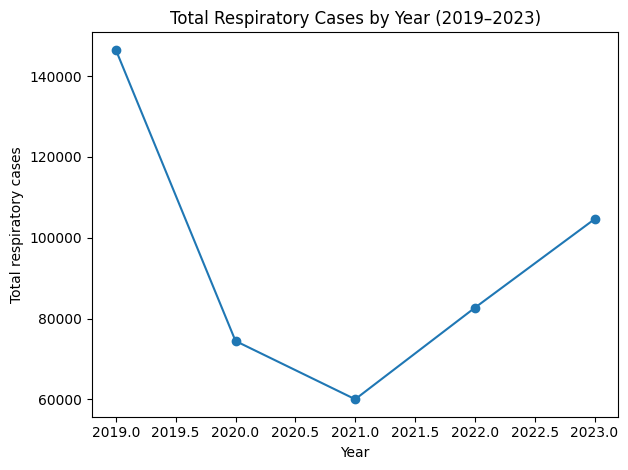

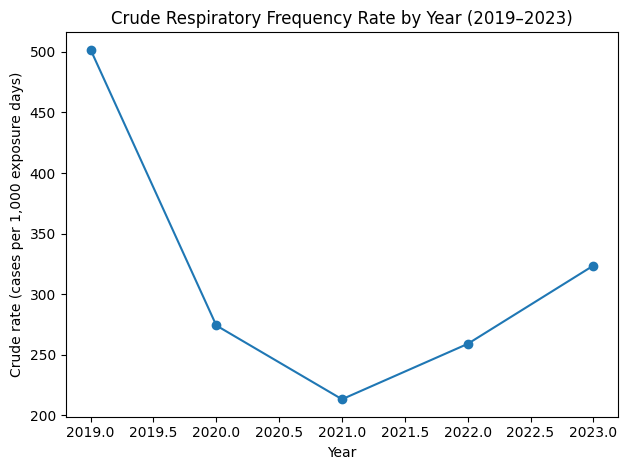

In [9]:
# Plot 1: Total cases by year
plt.figure()
plt.plot(tbl_year["treat_year"], tbl_year["total_cases"], marker="o")
plt.xlabel("Year")
plt.ylabel("Total respiratory cases")
plt.title("Total Respiratory Cases by Year (2019–2023)")
plt.tight_layout()
plt.show()

# Plot 2: Crude rate per 1,000 exposure days by year
plt.figure()
plt.plot(tbl_year["treat_year"], tbl_year["crude_rate_per_1000_days"], marker="o")
plt.xlabel("Year")
plt.ylabel("Crude rate (cases per 1,000 exposure days)")
plt.title("Crude Respiratory Frequency Rate by Year (2019–2023)")
plt.tight_layout()
plt.show()


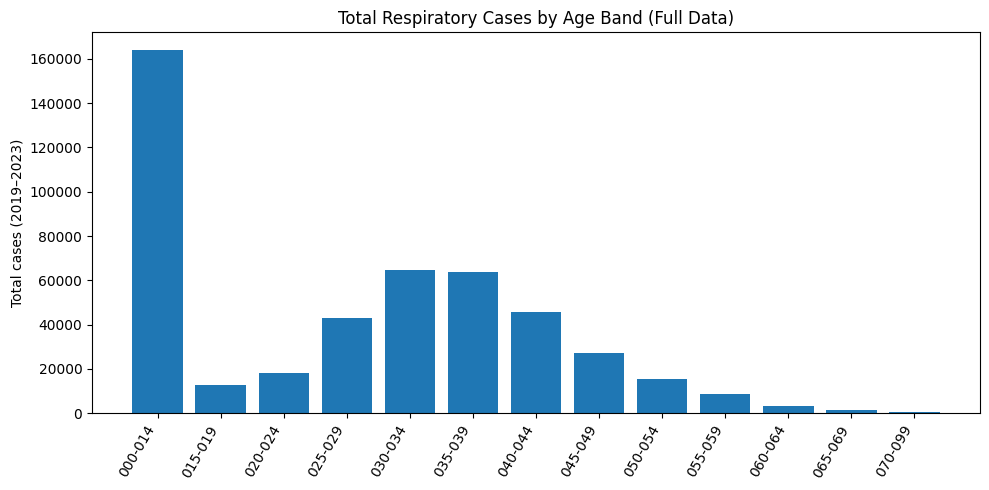

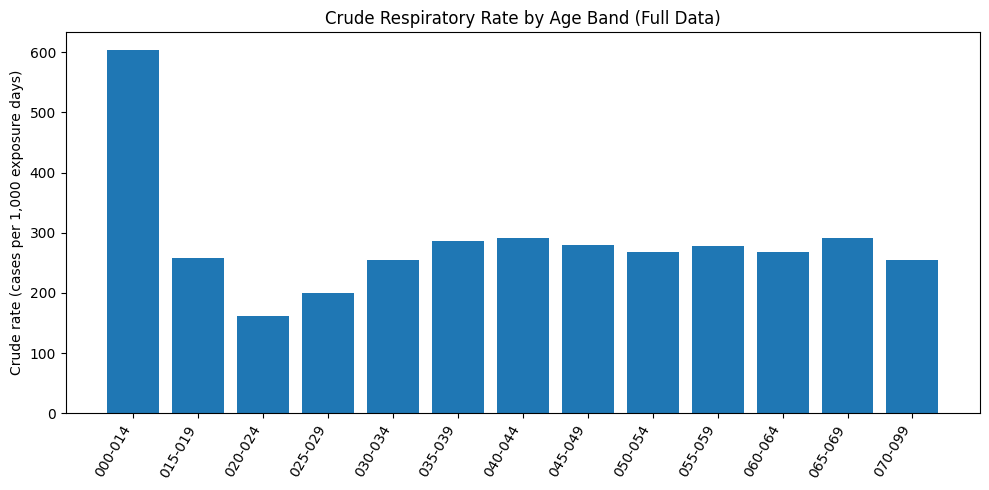

In [10]:
# Plot 3: Total cases by Age Band
age_plot = tbl_age.sort_values("AGEBAND").copy()
x = np.arange(len(age_plot))

plt.figure(figsize=(max(10, len(age_plot)*0.45), 5))
plt.bar(x, age_plot["total_cases"].values)
plt.xticks(x, age_plot["AGEBAND"].astype(str).values, rotation=60, ha="right")
plt.ylabel("Total cases (2019–2023)")
plt.title("Total Respiratory Cases by Age Band (Full Data)")
plt.tight_layout()
plt.show()

# Plot 4: Crude rate by Age Band (cases per 1,000 days)
plt.figure(figsize=(max(10, len(age_plot)*0.45), 5))
plt.bar(x, age_plot["crude_rate_per_1000_days"].values)
plt.xticks(x, age_plot["AGEBAND"].astype(str).values, rotation=60, ha="right")
plt.ylabel("Crude rate (cases per 1,000 exposure days)")
plt.title("Crude Respiratory Rate by Age Band (Full Data)")
plt.tight_layout()
plt.show()


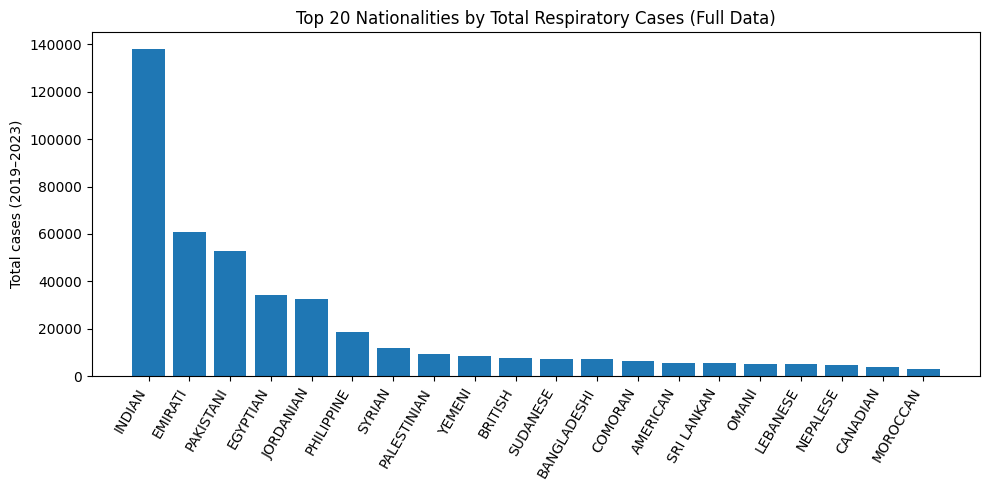

In [11]:
# Plot 5: Top 20 nationalities by total cases
nat_plot = tbl_nationality_top20.copy()
x = np.arange(len(nat_plot))

plt.figure(figsize=(max(10, len(nat_plot)*0.45), 5))
plt.bar(x, nat_plot["total_cases"].values)
plt.xticks(x, nat_plot["nationality"].astype(str).values, rotation=60, ha="right")
plt.ylabel("Total cases (2019–2023)")
plt.title("Top 20 Nationalities by Total Respiratory Cases (Full Data)")
plt.tight_layout()
plt.show()
